Simulated dataset Parametrized Principal Component Analysis (PPCA)

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matrices
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import copy
import gd
import compute
import weights
import scipy

**I Experiment:**

Creating dataset

In [2]:
# Setting seed
np.random.seed(0)

In [3]:
# Number of observations
n = 45
# Dimension
K = 3

m = 2
#theta = np.linspace(0,360,15)

# Functions of the model
def mu_true(par):
    return np.zeros((3,np.shape(par)[0]))
    # return np.array([np.sin((7*np.pi/720)*par), (-91/1800)*par+8, np.sin((7*np.pi/576)*par+0.6)])
    # return [np.sin((7*np.pi/720)*par), (-91/1800)*par+8, np.sin((7*np.pi/576)*par+0.6)]
def P_true(par):
    p1_true = np.array([np.sin((7*np.pi/1080)*par+0.4), np.tan((7*np.pi/4860)*par-0.8), (49/1800)*par-1.1])
    p2_true = np.array([np.cos((7*np.pi/972)*par), np.cos((7*np.pi/576)*par-0.4), (7/600)*par+1.4])
    
    # p1_true = [np.sin((7*np.pi/1080)*par+0.4), np.tan((7*np.pi/4860)*par-0.8), (49/1800)*par-1.1]
    # p2_true = [np.cos((7*np.pi/972)*par), np.cos((7*np.pi/576)*par-0.4), (7/600)*par+1.4]
    return p1_true,p2_true

# Coeff. taken from U(-1,1)
beta = np.random.uniform(-1,1,size=(m, n))
# Added normal noise
noise = np.random.normal(0,1,size=(K, n))

theta_true = np.arange(4,357,8)
#print(beta[:,0].shape)
p1_true,p2_true = P_true(theta_true)
#print(np.shape(p1_true))
#test = (p1_true*beta[0])[:,0]
#print(test)
#print(P_true(0)[0].shape)

Model:
$$
    x_{i} = \mu (\theta_{i}) + P(\theta_{i}) \beta_{i}
$$

In [4]:
# Creation of the dataset from known functions

data = mu_true(theta_true) + p1_true*beta[0] +p2_true*beta[1] + noise
data = np.concatenate((data,theta_true.reshape(1,-1)))
#data = np.c_[data, theta_true].T
print(np.shape(data))
#print(data[:2,:3])
#pd.DataFrame({key:value for key,value in zip(["x1","x2","x3","theta"],data)})
#print(mu_true(4) +P_true(4)[0]*beta[0,0] +P_true(4)[1]*beta[1,0]+noise[:,0])

(4, 45)


In [5]:
# num. of bins
nbins = 14
# 14 equally spaced bins
theta = np.linspace(0,360,nbins+1)
# length of each bin
bin_length = 360/nbins
# total num. of iteration
n_c = 1000
# num. of iteration for bases
n_v = 500
# orthonormality coeff
lambda_0 = 20
# smoothing coeff
lambda_m = 4.2
lambda_v = 0.008

In [6]:
def update_betas(n, data, w_l, w_u, mu_prec, bases, theta, theta_low, theta_up):
    update = []
    for i in range(n):
        P = compute.compute_P(w_l, w_u, bases, theta, theta_low, theta_up, i)
        P_inv = np.linalg.pinv(P)
        res = (data[:3,i]-compute.compute_mu(w_l, w_u, mu_prec, theta, theta_low, theta_up, i))
        update.append(P_inv @ res)

    update = np.stack(update)
    return update

In [7]:
def compute_losses(x, mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up):
    E_data = 0
    #mu_bin = x[:mu_len].reshape((nbins+1,K))
    bases = x.reshape(((nbins+1)*m,K)).reshape((nbins+1,m,K))
    #betas = x[mu_len+p_len:].reshape((n,m))

    betas = update_betas(n, data, w_l, w_u, np.zeros((nbins+1,K)), bases, theta, theta_low, theta_up)
    # # Normalize bases
    # for b in range(nbins+1):
    #     bases[b] = normalize(bases[b], axis=1)
    #     #print(np.linalg.norm(bases[b][0]))
    #     #print(np.linalg.norm(bases[b][1]))
    
    for i in range(n):
        p1_new = compute.compute_P(w_l, w_u, bases, theta, theta_low, theta_up, i)[:,0]/np.linalg.norm(compute.compute_P(w_l, w_u, bases, theta, theta_low, theta_up, i)[:,0])
        p2_new = compute.compute_P(w_l, w_u, bases, theta, theta_low, theta_up, i)[:,1]/np.linalg.norm(compute.compute_P(w_l, w_u, bases, theta, theta_low, theta_up, i)[:,1])
        res = data[:3,i]- np.vstack((p1_new,p2_new)).T @ betas[i]
        E_data += (np.linalg.norm(res)**2)
    E_data = E_data/n

    E_smo = 0
    res_mu = 0
    res_bas = 0
    E_ort = 0
    for b in range(nbins):
        for v in range(m):
            b1 = bases[b][v]/np.linalg.norm(bases[b][v])
            b2 = bases[b+1][v]/np.linalg.norm(bases[b][v])
            res_bas += np.linalg.norm(b1-b2)**2
            for w in np.arange(v,m):
                if w == v:
                    ind = 1
                else:
                    ind = 0
                bv = bases[b][v]/np.linalg.norm(bases[b][v])
                bw = bases[b][w]/np.linalg.norm(bases[b][w])
                E_ort += (np.dot(bv,bw)-ind)**2
    E_smo = lambda_v/nbins*(res_bas)
    E_ort = lambda_0*E_ort

    return E_data + E_smo + E_ort

In [8]:
def Sdist_inf(A, B):
    # return 1-max(np.abs(np.linalg.eigvals(A@B.T)))**2
    U, S, Vh =np.linalg.svd(A@B.T, full_matrices=False)
    return max(S)**2

In [9]:
def Sdist_sin(A,B):
    vals = np.linalg.eigvals(A@B.T)
    dist = 0
    for s in vals:
        dist += 1-s**2
    return np.sqrt(dist)

In [10]:
def Sdist_a(A,B):
    U, S, Vh =np.linalg.svd(A@B.T, full_matrices=False)
    dist = 0
    for s in S:
        dist += np.arccos(s)**2
    return np.sqrt(dist)

In [11]:
def Grass_base(s,s0,s1,theta,pca):
    # Function that implements base interpolation: s,s0,s1 are par value,par value low bin endp,par value up bin endp, theta=bins, pca contains pca object for every bin
    i_u = np.where(theta>=s)[0][0]
    # print(np.shape(pca))
    # print(i_u)
    # print('theta: ',s0,s,s1)
    A = pca[i_u-1].components_.T
    B = pca[i_u].components_.T
    inv_AB = np.linalg.inv(A.T@B+1e-10)
    mult = (np.eye(A.shape[0])-A@A.T)@B@inv_AB
    U, S, Vh = np.linalg.svd(mult, full_matrices=False)
    return A @ Vh.T @ np.diag(np.cos((s-s0)/(s1-s0)*np.arctan(S))) + U @ np.diag(np.sin((s-s0)/(s1-s0)*np.arctan(S)))

In [12]:
def create_dataset(endpoint,theta,data,nbins,n):
    train_grass = []
    # create train for first bin endpoint
    if endpoint == 0:
        count = 0
        while count<=10 and data[3,count]<=theta[1]:
            train_grass.append(data[:,count])
            count += 1
        train_grass = np.stack(train_grass).T
    # create train for last bin endpoint
    elif endpoint == nbins:
        count = n-1
        while count>=n-10 and data[3,count]>theta[nbins-1]:
            train_grass.insert(0,data[:,count])
            count -= 1
        train_grass = np.stack(train_grass).T
    
    else:
        # create train for middle bin endpoints
        index = np.where(np.squeeze(data[3,np.where(data[3,:]<=theta[endpoint+1]/2)]) > theta[endpoint-1]/2)
        train_grass = np.squeeze(data[:,index])

    return train_grass[:3,]

In [13]:
def compute_ker_data(par,data,gamma,size):
    data_new = np.zeros(data.shape)
    data_new[3,] = data[3,]
    for i in range(size):
        data_new[:3,i] = np.exp(-((par-data[3,i])**2)/gamma)*data[:3,i]

    ker_pca = PCA(n_components=m)
    ker_pca.fit(data_new[:3,:].T)
    proj_ker_PCA = ker_pca.transform(data[:3,0].T.reshape((1,-1)))
    return proj_ker_PCA @ ker_pca.components_

In [14]:
# def compute_ker_data(par,data,gamma):
#     data_new = np.zeros(data.shape)
#     data_new[3,] = data[3,]
#     for i in range(n):
#         data_new[:3,i] = np.exp(-((par-data[3,i])**2)/gamma)*data[:3,i]

#     ker_pca = PCA(n_components=m)
#     ker_pca.fit(data_new[:3,:].T)
#     proj_ker_PCA = ker_pca.transform(data[:3,0].T.reshape((1,-1)))
#     return proj_ker_PCA @ ker_pca.components_

# err = []
# for gamma in np.linspace(0.01,1):
#     data_ker = np.zeros(data.shape)
#     data_ker[3,] = data[3,]
#     for i in range(n):
#         data_ker[:3,i] = compute_ker_data(data[3,i],data,gamma)

#     err.append(np.sqrt(mean_squared_error(data[:3,].T, data_ker[:3,].T)))

# plt.plot(np.linspace(0.01,1),err)
# plt.show

Implementing the algorithm

In [15]:
n_train = 200
split_ratio = 0.25
rmse_PPCA = []
rmse_PCA = []
rmse_SPCA = []
rmse_IPCA = []
rmse_grass = []
rmse_test_PPCA = []
rmse_test_PCA = []
rmse_test_SPCA = []
rmse_test_IPCA = []
rmse_test_grass = []
err_bases_theta = []
err_bases_grass_theta = []
err_ker_train = []
err_ker_test = []
for n in np.arange(40,n_train+1,20):
    print(n)
    # Creating training and test set
    np.random.seed(0)
    theta_sample = np.linspace(0,360,int(n*(1+split_ratio)))
    theta_true = np.linspace(0,360,n)
    theta_test = np.setdiff1d(theta_sample,theta_true)
    theta_test = np.sort(np.random.choice(theta_test, (int(n*split_ratio),), replace=False))

    #print(beta[:,0].shape)
    beta = np.random.uniform(-1,1,size=(m, n))
    beta_test = np.random.uniform(-1,1,size=(m, int(n*split_ratio)))
    noise = np.random.normal(0,1,size=(K, n))
    noise_test = np.random.normal(0,1,size=(K, int(n*split_ratio)))
    p1_true,p2_true = P_true(theta_true)
    p1_test,p2_test = P_true(theta_test)
    data = mu_true(theta_true) + p1_true*beta[0] +p2_true*beta[1] + noise
    data = np.concatenate((data,theta_true.reshape(1,-1)))
    data_test = mu_true(theta_test) + p1_test*beta_test[0] +p2_test*beta_test[1] + noise_test
    data_test = np.concatenate((data_test,theta_test.reshape(1,-1)))

    # Setting the weights
    theta_up, theta_low, w_l, w_u, w_bn = weights.setting_weights(n, nbins, data, theta)
    # Initialization
    mu_0, bases_0, betas_0 = compute.initialization(n, nbins, m, data, w_bn, w_l, w_u, theta, theta_low, theta_up)
    mean_0 = mu_0.reshape(((nbins+1)*K,))
    p_0 = bases_0.reshape(((nbins+1)*m*K,))
    #b_0 = betas_0.reshape((n*m,))
    #x_0 = np.concatenate((mean_0,p_0))
    mu_len = mean_0.shape[0]
    p_len = p_0.shape[0]
    #beta_len = b_0.shape[0]
    mu_history = [mu_0]
    bases_history = [bases_0]
    betas_history = [betas_0]
    # Compute E_{0}
    E_0 = compute_losses(p_0,mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up)
    E_history = [E_0]
    #print(E_0)
    # Optimization
    W, C_M, R_M = matrices.mean(n,nbins,K,m,w_bn,betas_0) # m, betas_0 are not used in closed-form solution
    # for c in range(n_c):
    #print(c)
    # mean = mu_history[c].reshape(((nbins+1)*K,))
    # p = bases_history[c].reshape(((nbins+1)*m*K,))
    # b = betas_history[c].reshape((n*m,))
    # x = np.concatenate((mean,p,b))
    
    res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})
    print(res.message)
    # Mu
    mu = np.zeros((nbins+1,K))
    mu_history.append(mu)
    # P
    bases = res.x.reshape(((nbins+1)*m,K)).reshape((nbins+1,m,K))
    bases_history.append(bases)
    # Betas
    #betas = res.x[mu_len+p_len:].reshape((n,m))
    betas = update_betas(n, data, w_l, w_u, mu, bases, theta, theta_low, theta_up)
    betas_history.append(betas)
    # Loss
    # E_history.append(compute_losses(res.x, mu_len, p_len, beta_len, n, nbins, w_l, w_u, theta, theta_low, theta_up))
    # if E_history[c+1] > E_history[c]:
    #         break

    # Normalize bases
    for b in range(nbins+1):
        bases[b] = normalize(bases[b], axis=1)
        
    # Difference from real bases PPCA
    p1,p2 = P_true(theta)
    bases_true = np.stack([p1.T,p2.T]).swapaxes(0,1)
    err_bases= []
    for b in range(nbins+1):
        err_bases.append(Sdist_inf(bases[b].T,bases_true[b].T))   
    err_bases_theta.append(err_bases)

    # Standard PCA
    pca = PCA(n_components=m)
    data_red_PCA = pca.fit_transform(data[:3,:].T)
    data_PCA = pca.inverse_transform(data_red_PCA)
    
    proj_test_PCA = pca.transform(data_test[:3,:].T)
    data_test_PCA = pca.inverse_transform(proj_test_PCA)

    # Sparse PCA
    spca = SparsePCA(n_components=m).fit(data[:3,:].T)
    spca_transf = spca.transform(data[:3,:].T)
    data_SPCA = (spca_transf @ spca.components_) + spca.mean_

    proj_test_SPCA = spca.transform(data_test[:3,:].T)
    data_test_SPCA = (proj_test_SPCA @ spca.components_) + spca.mean_

    # IPCA
    index_l = np.where(data[3,:]>=theta[0])[0][0]
    index_u = np.where(data[3,:]<theta[1])[0][-1]
    ipca = [PCA(n_components=m)]
    ipca_transf = ipca[0].fit_transform(data[:3,index_l:index_u+1].T)
    data_IPCA = ipca[0].inverse_transform(ipca_transf)

    for b in range(2,nbins+1):
        index_l = np.where(data[3,:]>theta[b-1])[0][0]
        index_u = np.where(data[3,:]<=theta[b])[0][-1]
        ipca.append(PCA(n_components=m))
        if data[:3,index_l:index_u+1].T.shape[0] == 0:
            break
        ipca_transf = ipca[b-1].fit_transform(data[:3,index_l:index_u+1].T)
        # mu_ipca = ipca.mean_
        # bases_ipca = ipca.components_
        data_IPCA = np.concatenate((data_IPCA,ipca[b-1].inverse_transform(ipca_transf)),axis=0)
    
    up, low = weights.get_bounds(data_test[3][0].reshape((1,)),theta)
    for b in range(nbins):
        if theta[b] == low and theta[b+1] == up:
            proj_test_IPCA = ipca[b].transform(data[:3,0].reshape((1,-1)))
            data_test_IPCA = ipca[b].inverse_transform(proj_test_IPCA)
            break
    
    for i in range(1,int(n*split_ratio)):
        up, low = weights.get_bounds(data_test[3][i].reshape((1,)),theta)
        for b in range(nbins):
            if theta[b] == low and theta[b+1] == up:
                proj_test_IPCA = ipca[b].transform(data_test[:3,i].reshape((1,-1)))
                data_test_IPCA = np.concatenate((data_test_IPCA,ipca[b].inverse_transform(proj_test_IPCA)),axis=0)
                break

    #print(E_history[c+1])
    data_PPCA = np.zeros((data[:3,:].shape))
    data_test_PPCA = np.zeros((data_test[:3,:].shape))
    for i in range(n):
        data_PPCA[:,i] = compute.compute_mu(w_l, w_u, mu, theta, theta_low, theta_up, i)+compute.compute_P(w_l, w_u, bases, theta, theta_low, theta_up, i) @ betas[i]
        

    theta_up_t, theta_low_t, w_l_t, w_u_t, w_bn_t = weights.setting_weights(int(n*split_ratio), nbins, data_test, theta)

    # Grass
    bin_pca =[]
    for b in range(nbins+1):
        pca = PCA(n_components=m)
        bin_pca.append(pca.fit(create_dataset(b,theta,data,nbins,n).T))

    # train set
    g_base = Grass_base(data[3,0],theta_low[0],theta_up[0],theta,bin_pca)
    proj_grass = np.linalg.pinv(g_base) @ data[:3,0]
    data_grass = proj_grass @ g_base.T        
    
    for i in range(1,n):
        g_base = Grass_base(data[3,i],theta_low[i],theta_up[i],theta,bin_pca)
        proj_grass = np.linalg.pinv(g_base) @ data[:3,i]
        data_grass = np.vstack((data_grass,proj_grass @ g_base.T))

    # test set
    g_base = Grass_base(data_test[3,0],theta_low_t[0],theta_up_t[0],theta,bin_pca)
    proj_grass = np.linalg.pinv(g_base) @ data_test[:3,0]
    data_test_grass = proj_grass @ g_base.T        
    
    for i in range(1,int(n*split_ratio)):
        g_base = Grass_base(data_test[3,i],theta_low_t[i],theta_up_t[i],theta,bin_pca)
        proj_grass = np.linalg.pinv(g_base) @ data_test[:3,i]
        data_test_grass = np.vstack((data_test_grass,proj_grass @ g_base.T))

    # # Difference from real bases Grass
    # p1,p2 = P_true(theta_test)
    # bases_true_test = np.stack([p1.T,p2.T]).swapaxes(0,1)
    # err_bases_grass= []
    # for b in range(nbins+1):
    #     err_bases_grass.append(Sdist_inf(bin_pca[b].components_.T,bases_true_test[b].T))   
    # err_bases_grass_theta.append(err_bases_grass)

    # Kernel
    data_ker = np.zeros(data.shape)
    data_ker[3,] = data[3,]
    for i in range(n):
        data_ker[:3,i] = compute_ker_data(data[3,i],data,0.075,n)

    err_ker_train.append(np.sqrt(mean_squared_error(data[:3,].T, data_ker[:3,].T)))

    data_ker_test = np.zeros(data_test.shape)
    data_ker_test[3,] = data_test[3,]
    for i in range(int(n*split_ratio)):
        data_ker[:3,i] = compute_ker_data(data_test[3,i],data_test,0.075,int(n*split_ratio))

    err_ker_test.append(np.sqrt(mean_squared_error(data_test[:3,].T, data_ker_test[:3,].T)))

    betas_test = update_betas(int(n*split_ratio), data_test, w_l_t, w_u_t, mu, bases, theta, theta_low_t, theta_up_t)

    for i in range(int(n*split_ratio)):
        data_test_PPCA[:,i] = compute.compute_mu(w_l_t, w_u_t, mu, theta, theta_low_t, theta_up_t, i)+compute.compute_P(w_l_t, w_u_t, bases, theta, theta_low_t, theta_up_t, i) @ betas_test[i]
    
    # print("PPCA:",np.sqrt(mean_squared_error(data[:3,:].T, data_PPCA.T)))
    rmse_PPCA.append(np.sqrt(mean_squared_error(data[:3,:].T, data_PPCA.T)))
    rmse_PCA.append(np.sqrt(mean_squared_error(data[:3,:].T, data_PCA)))
    rmse_SPCA.append(np.sqrt(mean_squared_error(data[:3,:].T, data_SPCA)))
    rmse_IPCA.append(np.sqrt(mean_squared_error(data[:3,:].T, data_IPCA)))
    rmse_grass.append(np.sqrt(mean_squared_error(data[:3,:].T, data_grass)))

    rmse_test_PPCA.append(np.sqrt(mean_squared_error(data_test[:3,:].T, data_test_PPCA.T)))
    rmse_test_PCA.append(np.sqrt(mean_squared_error(data_test[:3,:].T, data_test_PCA)))
    rmse_test_SPCA.append(np.sqrt(mean_squared_error(data_test[:3,:].T, data_test_SPCA)))
    rmse_test_IPCA.append(np.sqrt(mean_squared_error(data_test[:3,:].T, data_test_IPCA)))
    rmse_test_grass.append(np.sqrt(mean_squared_error(data_test[:3,:].T, data_test_grass)))
    

40


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.
60


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.
80


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.
100


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.
120


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.
140


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.
160


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.
180


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.
200


C:\Users\enogj\AppData\Local\Temp\ipykernel_7292\3204245092.py:65: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = scipy.optimize.minimize(compute_losses, p_0, args=(mu_len, p_len, data, n, nbins, w_l, w_u, theta, theta_low, theta_up), method='Nelder-Mead', tol=0.005, options = {'maxiter':500,'disp':True})


Maximum number of iterations has been exceeded.


In [17]:
np.shape(err_ker_train)

(9,)

In [18]:
print(rmse_PPCA)
print(rmse_PCA)
print(rmse_SPCA)
print(rmse_IPCA)
print(rmse_grass)
print(err_bases)
print(err_ker_train)

[0.3951432096895128, 0.46455429201006015, 0.43090315192361905, 0.43204153388038347, 0.537396689880459, 0.5003141963199261, 0.48140440092543213, 0.48644153468112883, 0.5220496374665176]
[0.6075418561482806, 0.5830796046260518, 0.5907184946561739, 0.6103864427253498, 0.661581512879688, 0.6210000799418774, 0.597144483943672, 0.6259942392570695, 0.6232742098486687]
[0.6230823156535501, 0.5991058231383662, 0.5979206511323265, 0.6333423249331586, 0.6632075495330418, 0.626242088727246, 0.5995945474972008, 0.6282216536975705, 0.6326074838721071]
[7.11141561592309e-16, 0.18786627634512962, 0.28905601800709047, 0.33998396314760104, 0.430743687292349, 0.38250143981072054, 0.4396057593262379, 0.4459611510810496, 0.4748304548773516]
[0.8344913570764052, 1.221295438536277, 0.7358256838223924, 0.8196028114322851, 0.6934387993813854, 0.7538778731034634, 0.7394493477825913, 0.826003255728843, 0.7194693701849261]
[5.33371625803077, 4.446424342341312, 4.481630589373207, 7.252396490243727, 10.646175587740

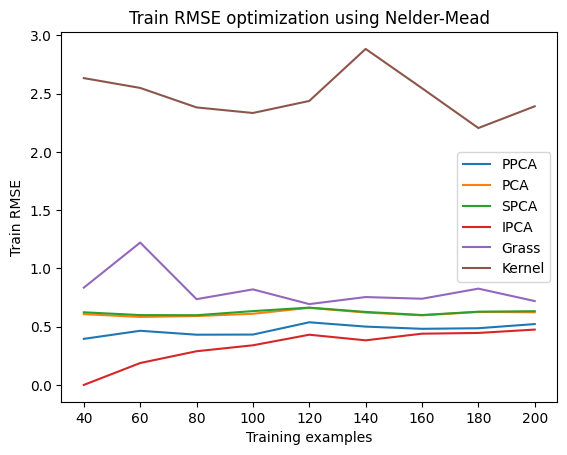

In [19]:
plt.plot(np.arange(40,n_train+1,20),rmse_PPCA, label="PPCA")
plt.plot(np.arange(40,n_train+1,20),rmse_PCA, label="PCA")
plt.plot(np.arange(40,n_train+1,20),rmse_SPCA, label="SPCA")
plt.plot(np.arange(40,n_train+1,20),rmse_IPCA, label="IPCA")
plt.plot(np.arange(40,n_train+1,20),rmse_grass, label="Grass")
plt.plot(np.arange(40,n_train+1,20),err_ker_train, label="Kernel")
# plt.ylim(0.4,2)
# plt.ylim(-0.01,0.85)
plt.title("Train RMSE optimization using Nelder-Mead")
plt.xlabel("Training examples")
plt.ylabel("Train RMSE")
plt.legend() 
plt.show
plt.savefig("grass_plot/no_mu_NelderMead_train_ker")

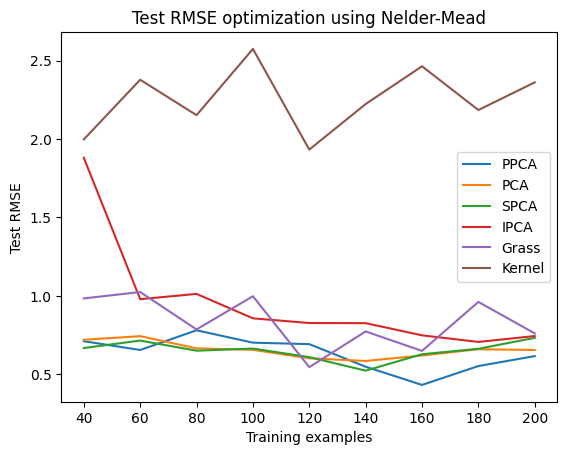

In [20]:
plt.plot(np.arange(40,n_train+1,20),rmse_test_PPCA, label="PPCA")
plt.plot(np.arange(40,n_train+1,20),rmse_test_PCA, label="PCA")
plt.plot(np.arange(40,n_train+1,20),rmse_test_SPCA, label="SPCA")
plt.plot(np.arange(40,n_train+1,20),rmse_test_IPCA, label="IPCA")
plt.plot(np.arange(40,n_train+1,20),rmse_test_grass, label="Grass")
plt.plot(np.arange(40,n_train+1,20),err_ker_test, label="Kernel")
# plt.ylim(0.4,2)
#plt.xlim(0,10)
plt.title("Test RMSE optimization using Nelder-Mead")
plt.xlabel("Training examples")
plt.ylabel("Test RMSE")
plt.legend() 
plt.show
plt.savefig("grass_plot/no_mu_NelderMead_test_ker")

In [21]:
np.shape(err_bases_theta)

(9, 15)

<function matplotlib.pyplot.show(close=None, block=None)>

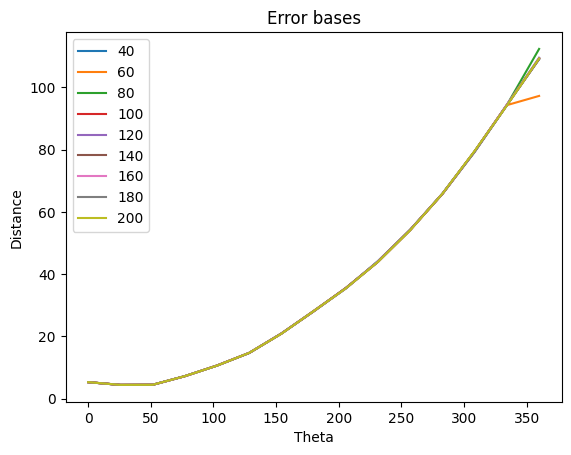

In [22]:
for i in range(9):
    plt.plot(theta,err_bases_theta[i], label=40+20*i)
plt.title("Error bases")
plt.xlabel("Theta")
plt.ylabel("Distance")
plt.legend() 
plt.show